# Capital Cost of Compression

### Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import MultipleLocator

import requests
from io import BytesIO

### Auxiliary Functions

In [ ]:
def calculate_compression_power(
    specific_heat_cp,
    mass_flow_rate,
    gas_constant,
    inlet_temp,
    molar_mass,
    isentropic_efficiency,
    pressure_ratio_per_stage,
    compression_ratio,
):
    """
    Calculates the isentropic compression power requirement per stage.

    Args:
        specific_heat_cp (float): Molar specific heat at constant pressure.
        mass_flow_rate (float): Mass flow rate.
        gas_constant (float): Universal gas constant.
        inlet_temp (float): Inlet temperature.
        molar_mass (float): Molar mass of the gas.
        isentropic_efficiency (float): Isentropic efficiency of the compressor.
        pressure_ratio_per_stage (float): Pressure ratio per stage.
        compression_ratio (float): Molar specific heat at constant volume (cv).

    Returns:
        tuple: A tuple containing:
            - specific_heat_ratio (float): Coefficient of adiabatic expansion (Cp/Cv).
            - stage_power (float): Compression power per stage in kW.
    """
    # Coefficient of Adiabatic Expansion
    kappa = 1000 / (24 * 3600)
    specific_heat_ratio = specific_heat_cp / compression_ratio
    co2_specific_heat_ratio = (specific_heat_ratio - 1) / specific_heat_ratio

    # Calculate the power [kW]
    stage_power = (
        kappa
        * (
            mass_flow_rate
            * compression_ratio
            * gas_constant
            * inlet_temp
            / (co2_specific_heat_ratio * molar_mass * isentropic_efficiency)
        )
        * (pressure_ratio_per_stage**co2_specific_heat_ratio - 1)
    )

    return specific_heat_ratio, stage_power


def transform_dataframe(df, value_name):
    """
    Performs transformations on annual cost Dataframes.

    Args:
        df(pd.DataFrame): The DataFrame to be transformed.
        value_name(str): The new name for the value column.

    Returns:
        pd.DataFrame: The transformed DataFrame.
    """
    df = df.reset_index()
    df = df.melt(id_vars=["Years"], var_name="Original Column", value_name="Value")
    df[["Group", "Type"]] = df["Original Column"].str.split(" - ", expand=True)
    df.drop(columns=["Original Column"], inplace=True)
    df.rename(columns={"Value": value_name}, inplace=True)
    return df


def get_ylim(y_min, y_max):
    delta = 0.25 * (y_max - y_min)
    return (y_min - delta, y_max + delta)


def config_plot(ax, y_values, x_lim, title, leg_loc="upper right", x_multiplelocator=2):
    y_min, y_max = min(y_values), max(y_values)
    y_min_lim, y_max_lim = get_ylim(y_min, y_max)
    y_baseline = np.mean([y_min, y_min_lim])
    ax.set_ylim([y_min_lim, y_max_lim])

    ax.xaxis.set_major_locator(MultipleLocator(x_multiplelocator))
    ax.set_xlim(x_lim)

    # ax.grid(color="w", axis="y")
    ax.grid(axis="y", alpha=0.1)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.legend(loc=leg_loc, fontsize="small")
    ax.set_title(title)


def plot_dataframes(df, list_of_companies, plot_config):
    """
    Generates a multi-subplot figure based on input DataFrame and a list of companies.

    Args:
        df (pd.DataFrame): The DataFrame containing the data to be plotted.
        list_of_companies (list): A list of company names used to select columns.
        plot_config (dict): A dictionary with plot-specific settings, including:
            - 'ylabel' (str): The label for the y-axis.
            - 'save_path' (str): The file path to save the generated plot.
            - 'colors' (dict): A dictionary mapping plot types (e.g., 'BAU') to colors.
    """
    fig, axs = plt.subplots(2, 3, figsize=(14, 6), constrained_layout=True, sharex=True)
    axs = axs.flatten()

    for company_id, company_name in enumerate(list_of_companies):
        ax = axs[company_id]
        X = df.index.values
        y_values = np.array([])  # Initialize with an empty array

        for plot_type, color in plot_config["colors"].items():
            column_name = f"{company_name} - {plot_type}"
            data = df.loc[:, column_name].values
            y_values = np.concatenate((y_values, data))
            ax.plot(X, data, color=color, label=plot_type)

        config_plot(
            ax,
            y_values,
            x_lim=[2025 - 0.5, 2031 - 0.5],
            title=company_name,
            x_multiplelocator=1,
        )

        if company_id in [0, 3]:
            ax.set_ylabel(plot_config["ylabel"])

        if company_id >= 3:
            ax.set_xlabel("$t \\, [year]$")

    fig.savefig(plot_config["save_path"], dpi=600, bbox_inches="tight")

### Data Reading

In [ ]:
# URL = "https://raw.githubusercontent.com/thiagoneye/costcaster/main/data/Forecast%20(MtCO2e).xlsx"
# response = requests.get(URL)

# df = pd.read_excel(BytesIO(response.content), engine="openpyxl")
df = pd.read_excel("../data/Forecast (MtCO2e).xlsx")

df.drop(columns="Unnamed: 0", inplace=True)
df.set_index("Years", inplace=True)
display(df)

list_of_companies = ["A-1", "C-1", "C-2", "P-1", "S-1", "S-2"]

,A-1 - BAU,A-1 - DBM,A-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,S-1 - BAU,S-1 - DBM,S-1 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,1.341908,1.252185,1.320980,1.579306,1.519020,1.554676,13.513428,13.340975,13.302679,2.283988,2.074743,2.248368,23.632865,18.060261,23.264298,8.940516,9.801581,8.801084
2026,1.341908,1.242492,1.300379,1.579306,1.519730,1.530430,13.513428,13.317894,13.095216,2.283988,1.921093,2.213303,23.632865,17.756772,22.901478,8.940516,9.772826,8.663826
2027,1.341908,1.239475,1.280099,1.579306,1.519925,1.506562,13.513428,13.317618,12.890989,2.283988,1.776351,2.178785,23.632865,17.540634,22.544317,8.940516,9.788235,8.528709
2028,1.341908,1.238880,1.260135,1.579306,1.519972,1.483066,13.513428,13.319519,12.689947,2.283988,1.657053,2.144806,23.632865,17.448469,22.192726,8.940516,9.823698,8.395699
2029,1.341908,1.238803,1.240482,1.579306,1.519983,1.459937,13.513428,13.319376,12.492040,2.283988,1.569028,2.111357,23.632865,17.423024,21.846618,8.940516,9.856964,8.264763
2030,1.341908,1.238796,1.221136,1.579306,1.519985,1.437168,13.513428,13.318683,12.297220,2.283988,1.510201,2.078429,23.632865,17.418340,21.505907,8.940516,9.878516,8.135870


### Variables

In [ ]:
inlet_pressure = 0.1  # Initial Pressure [MPa]
outlet_pressure = 7.38  # Compressor Outlet Pressure (Rename, now it's final) Po
num_stages = 4  # Number of Stages
molar_mass = 44.01  # Molar Mass of CO2 [kg/kmol]
gas_constant = 8.314  # Ideal Gas Constant [kJ/kmol*K]
inlet_temp = 313.15  # Inlet Temperature [K]
isentropic_efficiency = 0.82  # Compressor Isentropic Efficiency
mass_flow_rate = 25000  # CO2 Mass Flow Rate
temp_variation = 356  # Temperature Variation During Compression

compression_ratio_stage = [0.995, 0.986, 0.959, 0.875]  # Compression Ratio per Stage

# Energy Cost
energy_price = 0.082  # Energy Price
capacity_factor = 0.8  # Capacity Factor

# Capital Cost
capital_recovery_factor = 0.1275  # Capital Recovery Factor

# Operational & Maintenance Cost
oem_maintenance_factor = 0.05  # OEM Maintenance Operating Factor

In [5]:
COLORS = {
    "History": mcolors.CSS4_COLORS["darkslategray"],
    "Reference": mcolors.CSS4_COLORS["mediumturquoise"],
    "DBM": mcolors.CSS4_COLORS["goldenrod"],
    "GBM": mcolors.CSS4_COLORS["mediumseagreen"],
    "BAU": mcolors.CSS4_COLORS["indianred"],
}

### Analysis

In [6]:
kappa = 1000 / (24 * 3600)
pressure_ratio = outlet_pressure / inlet_pressure
pressure_ratio_per_stage = pressure_ratio ** (1 / num_stages)
specific_heat_cv = (
    13.946
    + (5.981e-2 * temp_variation)
    - (3.501e-5 * temp_variation**2)
    + (7.469e-9 * temp_variation**3)
) / 44.01
specific_heat_cp = (
    22.26
    + (5.981e-2 * temp_variation)
    - (3.501e-5 * temp_variation**2)
    + (7.469e-9 * temp_variation**3)
) / (44.01 * specific_heat_cv)

# Compression Power Requirement

stage_k = []
stage_power = []
for compression_ratio in compression_ratio_stage:
    k, power = calculate_compression_power(
        specific_heat_cp,
        mass_flow_rate,
        gas_constant,
        inlet_temp,
        molar_mass,
        isentropic_efficiency,
        pressure_ratio_per_stage,
        compression_ratio=compression_ratio,
    )
    stage_k.append(k)
    stage_power.append(power)

# Convertion to tCO2e

df = df * 1e6

# Carbon Capture Percentage

corrected_carbon_emissions = df.copy()
corrected_carbon_emissions = corrected_carbon_emissions * 0.76
display(corrected_carbon_emissions.round(0).astype(int))

,A-1 - BAU,A-1 - DBM,A-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,S-1 - BAU,S-1 - DBM,S-1 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,1019850,951660,1003945,1200273,1154455,1181554,10270205,10139141,10110036,1735831,1576805,1708759,17960978,13725798,17680866,6794792,7449201,6688824
2026,1019850,944294,988288,1200273,1154995,1163127,10270205,10121600,9952364,1735831,1460031,1682110,17960978,13495147,17405123,6794792,7427348,6584508
2027,1019850,942001,972875,1200273,1155143,1144987,10270205,10121390,9797152,1735831,1350027,1655877,17960978,13330882,17133681,6794792,7439059,6481819
2028,1019850,941549,957702,1200273,1155179,1127130,10270205,10122834,9644360,1735831,1259360,1630053,17960978,13260836,16866471,6794792,7466011,6380731
2029,1019850,941490,942767,1200273,1155187,1109552,10270205,10122726,9493950,1735831,1192461,1604631,17960978,13241498,16603429,6794792,7491293,6281220
2030,1019850,941485,928064,1200273,1155188,1092248,10270205,10122199,9345887,1735831,1147753,1579606,17960978,13237938,16344490,6794792,7507672,6183261


### Power Requirement

,A-1 - BAU,A-1 - DBM,A-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,S-1 - BAU,S-1 - DBM,S-1 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,10956,10223,10785,12894,12402,12693,110329,108921,108608,18647,16939,18356,192947,147451,189938,72994,80024,71855
2026,10956,10144,10617,12894,12408,12495,110329,108732,106914,18647,15684,18070,192947,144973,186976,72994,79789,70735
2027,10956,10120,10451,12894,12409,12300,110329,108730,105247,18647,14503,17788,192947,143208,184060,72994,79915,69631
2028,10956,10115,10288,12894,12410,12108,110329,108745,103605,18647,13529,17511,192947,142456,181189,72994,80204,68546
2029,10956,10114,10128,12894,12410,11919,110329,108744,101990,18647,12810,17238,192947,142248,178364,72994,80476,67477
2030,10956,10114,9970,12894,12410,11734,110329,108739,100399,18647,12330,16969,192947,142210,175582,72994,80652,66424


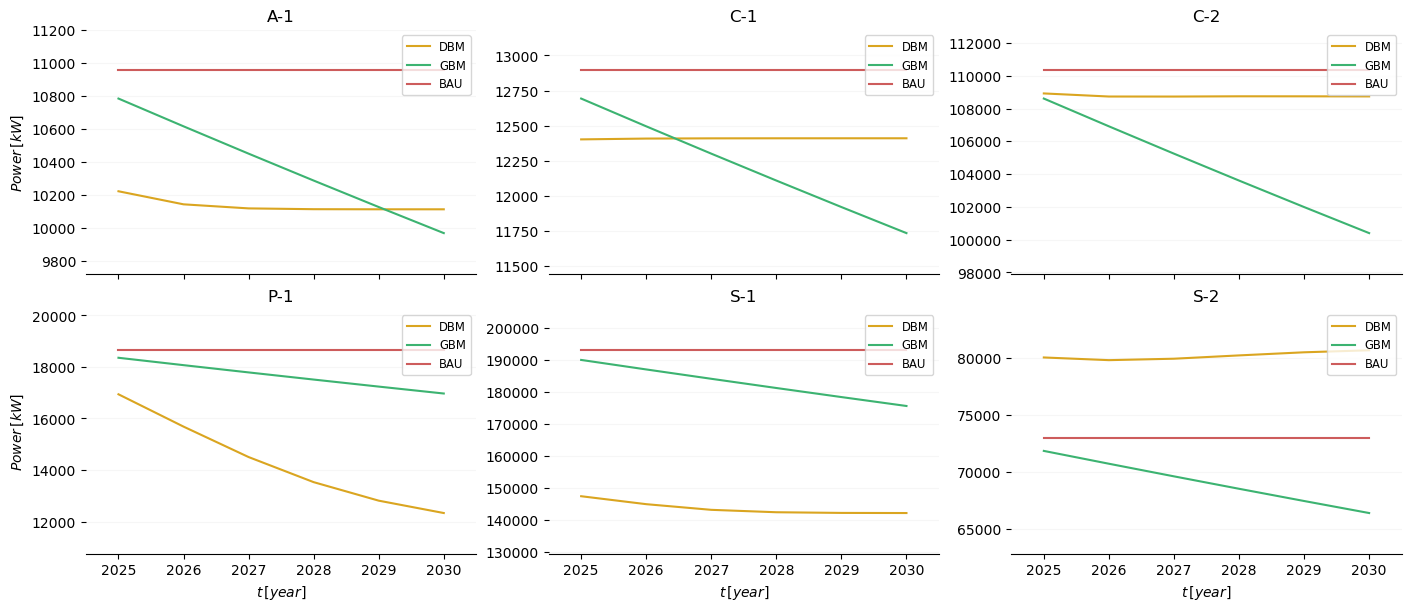

In [7]:
# Total Power Requirement [kW]

power_requirement = 0
for k, compression_ratio in zip(stage_k, compression_ratio_stage):
    # Calculates the power for the current stage
    power_per_stage = (
        (
            (corrected_carbon_emissions / 365)
            * compression_ratio
            * gas_constant
            * inlet_temp
            / (molar_mass * isentropic_efficiency)
        )
        * (k / (k - 1))
        * (pressure_ratio_per_stage ** (((k - 1) / k)) - 1)
    )

    # Totals the power
    power_requirement += power_per_stage

# Multiply the total result by the conversion factor
power_requirement *= kappa
display(power_requirement.round(0).astype(int))

# Plot

plot_power = {
    "ylabel": "$Power \\, [kW]$",
    "save_path": "../img/power_requirement.png",
    "colors": {
        "DBM": mcolors.CSS4_COLORS["goldenrod"],
        "GBM": mcolors.CSS4_COLORS["mediumseagreen"],
        "BAU": mcolors.CSS4_COLORS["indianred"],
    },
}
plot_dataframes(power_requirement, list_of_companies, plot_power)

### Capital Cost of Compression

,A-1 - BAU,A-1 - DBM,A-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,S-1 - BAU,S-1 - DBM,S-1 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,51717760,50311368,51394902,55185524,54336368,54840994,196991188,195985114,195760641,63924860,61523530,63525707,373459730,282197089,371126950,167082679,173320194,166039122
2026,51717760,50155862,51074061,55185524,54346488,54498617,196991188,195849875,194537788,63924860,59665867,63129049,373459730,280297050,368808755,167082679,173117337,165002090
2027,51717760,50107309,50755226,55185524,54349261,54158379,196991188,195848255,193322581,63924860,57832318,62734871,373459730,278931949,366505054,167082679,173226089,163971540
2028,51717760,50097718,50438383,55185524,54349939,53820268,196991188,195859398,192114971,63924860,56252339,62343156,373459730,278346773,364215755,167082679,173475990,162947433
2029,51717760,50096472,50123520,55185524,54350087,53484270,196991188,195858562,190914912,63924860,55042145,61953889,373459730,278184891,304442742,167082679,173709912,161929729
2030,51717760,50096364,49810625,55185524,54350115,53150372,196991188,195854500,189722356,63924860,54210463,61567056,373459730,278155078,302540924,167082679,173861207,160918387


,A-1 - BAU,A-1 - DBM,A-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,S-1 - BAU,S-1 - DBM,S-1 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,4721,4921,4765,4280,4381,4321,1785,1799,1802,3428,3632,3461,1936,1914,1954,2289,2166,2311
2026,4721,4944,4811,4280,4380,4362,1785,1801,1820,3428,3804,3494,1936,1933,1972,2289,2170,2333
2027,4721,4952,4856,4280,4380,4403,1785,1801,1837,3428,3988,3527,1936,1948,1991,2289,2168,2355
2028,4721,4953,4903,4280,4380,4445,1785,1801,1854,3428,4158,3560,1936,1954,2010,2289,2163,2377
2029,4721,4953,4949,4280,4380,4487,1785,1801,1872,3428,4297,3594,1936,1956,1707,2289,2159,2400
2030,4721,4953,4996,4280,4380,4530,1785,1801,1890,3428,4397,3628,1936,1956,1723,2289,2156,2423


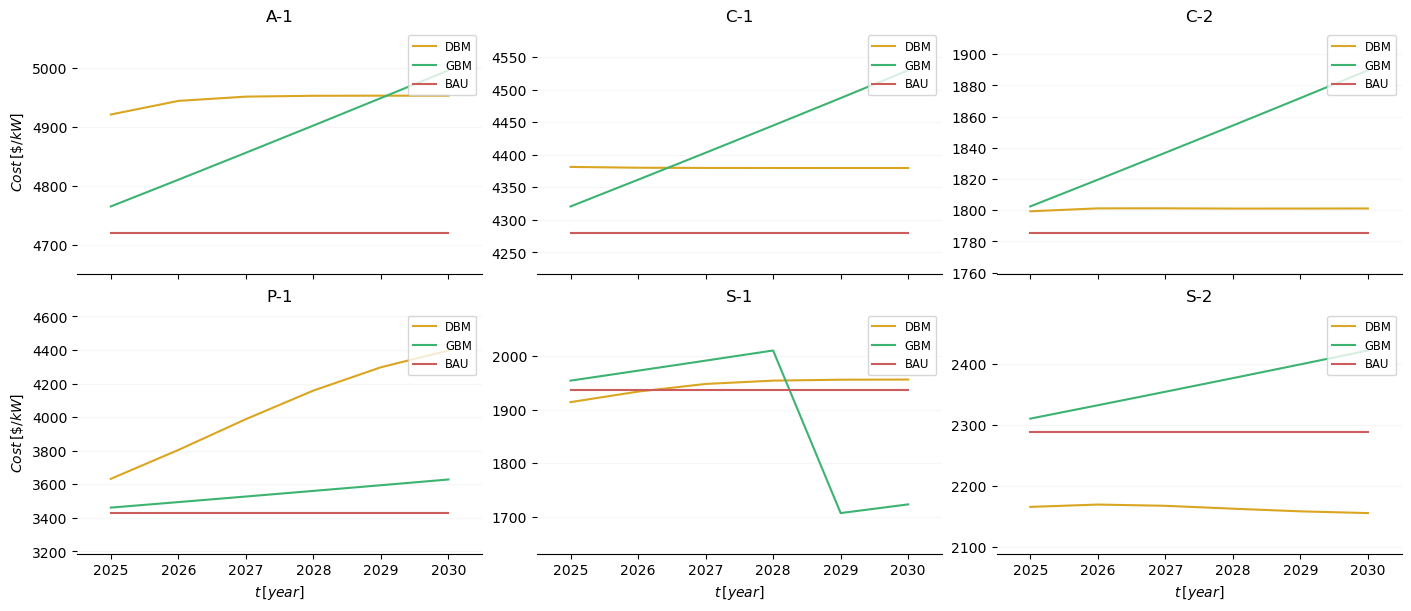

In [ ]:
# Capital Cost of Compression ($)

c1 = 0.13 * (10**6)
c2 = 1.4 * (10**6)
v = kappa * (corrected_carbon_emissions / 365) / (np.ceil(power_requirement / 60000))

capital_cost = (
    kappa
    * (corrected_carbon_emissions * 2.107 / 365)  # mass_flow_rate
    * ((c1 / (v**0.71)) + (c2 * np.log(pressure_ratio) / (v**0.6)))
)
display(capital_cost.round(0).astype(int))

# Capital Cost of Compression ($/kW)

capital_cost_per_power = capital_cost / power_requirement
display(capital_cost_per_power.round(0).astype(int))

# Plot

plot_cost = {
    "ylabel": "$Cost \\, [\$/kW]$",
    "save_path": "../img/capital_cost.png",
    "colors": {
        "DBM": mcolors.CSS4_COLORS["goldenrod"],
        "GBM": mcolors.CSS4_COLORS["mediumseagreen"],
        "BAU": mcolors.CSS4_COLORS["indianred"],
    },
}
plot_dataframes(capital_cost_per_power, list_of_companies, plot_cost)

### Annual Compression Capital Cost

In [ ]:
# Annual Energy Cost ($)

energy_cost = power_requirement*energy_price*capacity_factor*24*365
display(energy_cost.round(0).astype(int))

# Annual Capital Cost ($)

corrected_cost_of_capital = capital_cost*capital_recovery_factor
display(corrected_cost_of_capital.round(0).astype(int))

# Annual O&M Cost ($)

oem_cost = capital_cost*oem_maintenance_factor
display(oem_cost.round(0).astype(int))

# Total Annual Cost ($)

total_cost = corrected_cost_of_capital + oem_cost + energy_cost
display(total_cost.round(0).astype(int))

,A-1 - BAU,A-1 - DBM,A-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,S-1 - BAU,S-1 - DBM,S-1 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,6295830,5874875,6197643,7409630,7126785,7294073,63400950,62591850,62412177,10715785,9734073,10548666,110878313,84733324,109149104,41946219,45986075,41292044
2026,6295830,5829402,6100987,7409630,7130117,7180318,63400950,62483564,61438825,10715785,9013192,10384154,110878313,83309448,107446863,41946219,45851168,40648072
2027,6295830,5815247,6005839,7409630,7131030,7068337,63400950,62482268,60480652,10715785,8334107,10222207,110878313,82295390,105771169,41946219,45923462,40014142
2028,6295830,5812454,5912174,7409630,7131254,6958102,63400950,62491186,59537423,10715785,7774396,10062786,110878313,81862980,104121609,41946219,46089846,39390099
2029,6295830,5812091,5819971,7409630,7131302,6849586,63400950,62490517,58608903,10715785,7361407,9905851,110878313,81743600,102497775,41946219,46245919,38775789
2030,6295830,5812059,5729205,7409630,7131312,6742763,63400950,62487266,57694865,10715785,7085410,9751364,110878313,81721625,100899265,41946219,46347032,38171059


,A-1 - BAU,A-1 - DBM,A-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,S-1 - BAU,S-1 - DBM,S-1 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,6594014,6414699,6552850,7036154,6927887,6992227,25116377,24988102,24959482,8150420,7844250,8099528,47616116,35980129,47318686,21303042,22098325,21169988
2026,6594014,6394872,6511943,7036154,6929177,6948574,25116377,24970859,24803568,8150420,7607398,8048954,47616116,35737874,47023116,21303042,22072460,21037766
2027,6594014,6388682,6471291,7036154,6929531,6905193,25116377,24970652,24648629,8150420,7373621,7998696,47616116,35563824,46729394,21303042,22086326,20906371
2028,6594014,6387459,6430894,7036154,6929617,6862084,25116377,24972073,24494659,8150420,7172173,7948752,47616116,35489214,46437509,21303042,22118189,20775798
2029,6594014,6387300,6390749,7036154,6929636,6819244,25116377,24971967,24341651,8150420,7017874,7899121,47616116,35468574,38816450,21303042,22148014,20646040
2030,6594014,6387286,6350855,7036154,6929640,6776672,25116377,24971449,24189600,8150420,6911834,7849800,47616116,35464772,38573968,21303042,22167304,20517094


,A-1 - BAU,A-1 - DBM,A-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,S-1 - BAU,S-1 - DBM,S-1 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,2585888,2515568,2569745,2759276,2716818,2742050,9849559,9799256,9788032,3196243,3076176,3176285,18672987,14109854,18556348,8354134,8666010,8301956
2026,2585888,2507793,2553703,2759276,2717324,2724931,9849559,9792494,9726889,3196243,2983293,3156452,18672987,14014853,18440438,8354134,8655867,8250104
2027,2585888,2505365,2537761,2759276,2717463,2707919,9849559,9792413,9666129,3196243,2891616,3136744,18672987,13946597,18325253,8354134,8661304,8198577
2028,2585888,2504886,2521919,2759276,2717497,2691013,9849559,9792970,9605749,3196243,2812617,3117158,18672987,13917339,18210788,8354134,8673799,8147372
2029,2585888,2504824,2506176,2759276,2717504,2674214,9849559,9792928,9545746,3196243,2752107,3097694,18672987,13909245,15222137,8354134,8685496,8096486
2030,2585888,2504818,2490531,2759276,2717506,2657519,9849559,9792725,9486118,3196243,2710523,3078353,18672987,13907754,15127046,8354134,8693060,8045919


,A-1 - BAU,A-1 - DBM,A-1 - GBM,C-1 - BAU,C-1 - DBM,C-1 - GBM,C-2 - BAU,C-2 - DBM,C-2 - GBM,P-1 - BAU,P-1 - DBM,P-1 - GBM,S-1 - BAU,S-1 - DBM,S-1 - GBM,S-2 - BAU,S-2 - DBM,S-2 - GBM
Years,,,,,,,,,,,,,,,,,,
2025,15475732,14805142,15320238,17205061,16771491,17028349,98366886,97379208,97159691,22062447,20654499,21824479,177167415,134823308,175024138,71603394,76750409,70763988
2026,15475732,14732067,15166633,17205061,16776619,16853822,98366886,97246917,95969282,22062447,19603883,21589560,177167415,133062174,172910417,71603394,76579495,69935943
2027,15475732,14709295,15014891,17205061,16778024,16681449,98366886,97245333,94795410,22062447,18599343,21357647,177167415,131805811,170825816,71603394,76671093,69119091
2028,15475732,14704799,14864987,17205061,16778368,16511199,98366886,97256229,93637830,22062447,17759187,21128696,177167415,131269532,168769906,71603394,76881834,68313269
2029,15475732,14704215,14716896,17205061,16778443,16343044,98366886,97255411,92496300,22062447,17131388,20902667,177167415,131121418,156536361,71603394,77079428,67518316
2030,15475732,14704164,14570591,17205061,16778457,16176954,98366886,97251440,91370583,22062447,16707768,20679517,177167415,131094151,154600279,71603394,77207396,66734073


In [ ]:
# Transformation of Dataframes

corrected_cost_of_capital = transform_dataframe(corrected_cost_of_capital, "Cap")
display(corrected_cost_of_capital.round(0).astype(int))

oem_cost = transform_dataframe(oem_cost, "OEM")
display(oem_cost.round(0).astype(int))

energy_cost = transform_dataframe(energy_cost, "Power")
display(energy_cost.round(0).astype(int))

# Merging Dataframes

annual_cost = pd.merge(corrected_cost_of_capital, oem_cost, on=["Years", "Group", "Type"], how="outer")
annual_cost = pd.merge(
    annual_cost, energy_cost, on=["Years", "Group", "Type"], how="outer"
)
annual_cost = annual_cost.loc[:, ["Group", "Type", "Years", "Cap", "OEM", "Power"]]
display(df.round(0).astype(int))

,Years,Cap,Group,Type
0,2025,6.594014e+06,A-1,BAU
1,2026,6.594014e+06,A-1,BAU
2,2027,6.594014e+06,A-1,BAU
3,2028,6.594014e+06,A-1,BAU
4,2029,6.594014e+06,A-1,BAU
...,...,...,...,...
103,2026,2.103777e+07,S-2,GBM
104,2027,2.090637e+07,S-2,GBM
105,2028,2.077580e+07,S-2,GBM
106,2029,2.064604e+07,S-2,GBM


,Years,OEM,Group,Type
0,2025,2.585888e+06,A-1,BAU
1,2026,2.585888e+06,A-1,BAU
2,2027,2.585888e+06,A-1,BAU
3,2028,2.585888e+06,A-1,BAU
4,2029,2.585888e+06,A-1,BAU
...,...,...,...,...
103,2026,8.250104e+06,S-2,GBM
104,2027,8.198577e+06,S-2,GBM
105,2028,8.147372e+06,S-2,GBM
106,2029,8.096486e+06,S-2,GBM


,Years,Power,Group,Type
0,2025,6.295830e+06,A-1,BAU
1,2026,6.295830e+06,A-1,BAU
2,2027,6.295830e+06,A-1,BAU
3,2028,6.295830e+06,A-1,BAU
4,2029,6.295830e+06,A-1,BAU
...,...,...,...,...
103,2026,4.064807e+07,S-2,GBM
104,2027,4.001414e+07,S-2,GBM
105,2028,3.939010e+07,S-2,GBM
106,2029,3.877579e+07,S-2,GBM


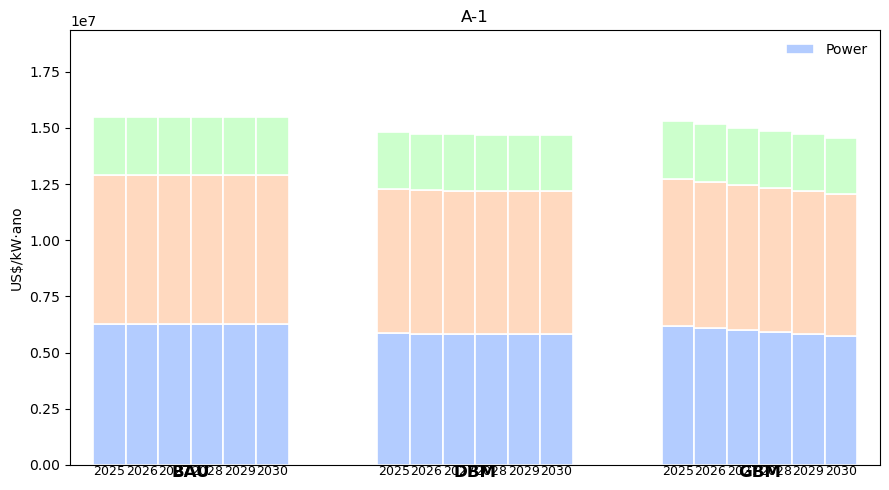

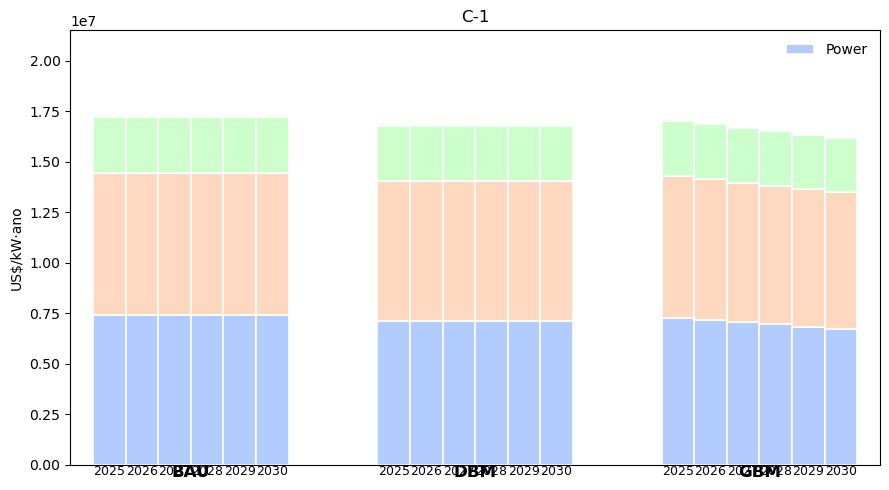

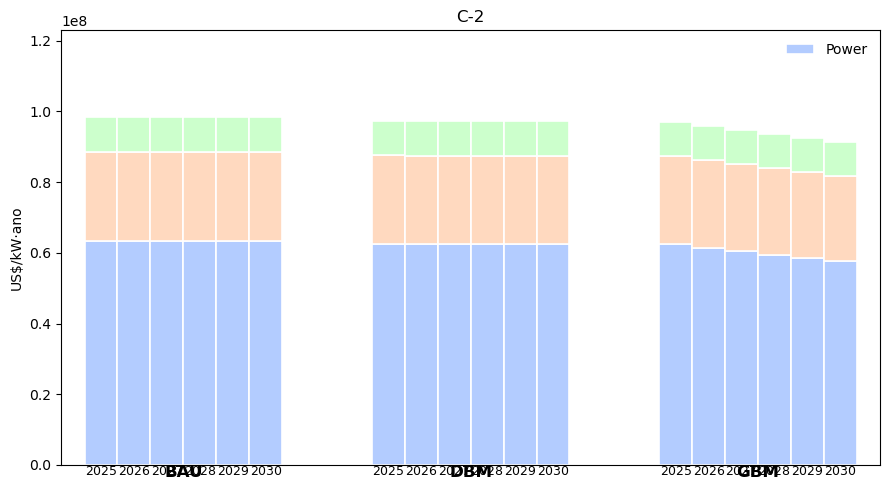

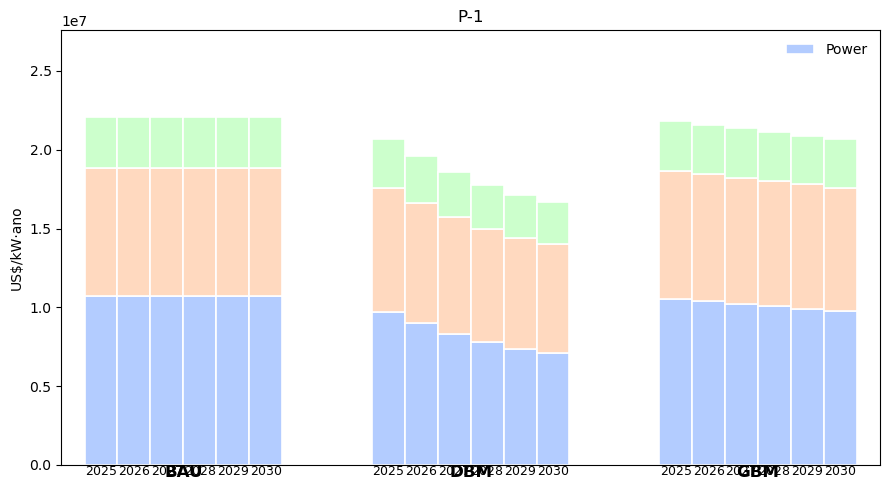

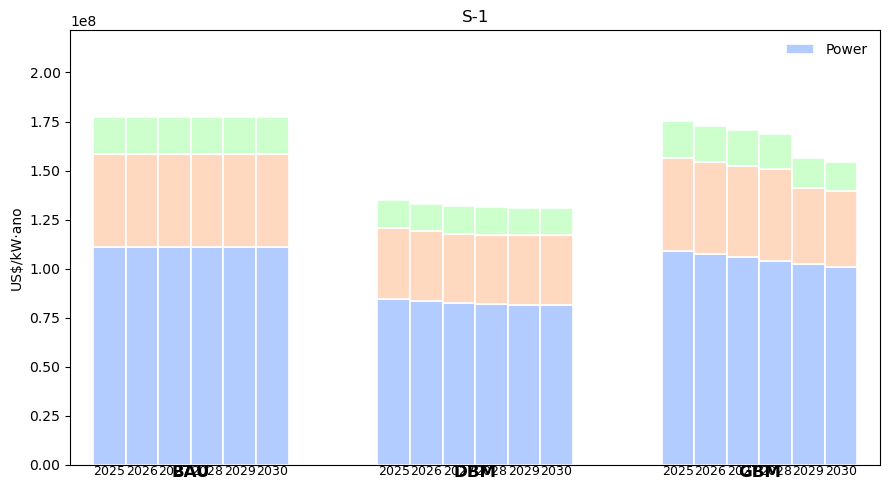

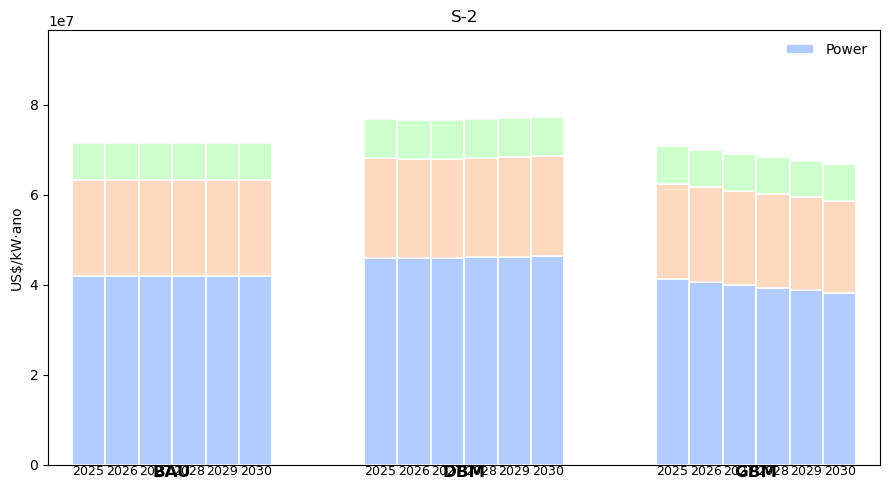

In [ ]:
# Parâmetros do layout
scenarios = ["BAU", "DBM", "GBM"]
years = annual_cost.Years.unique()
n_years = len(years)
bar_width = 0.22  # largura de cada barra (ano) dentro do grupo
gap = 0.60  # espaço entre grupos de cenários

# Posições dos grupos no eixo X
group_pos = np.arange(len(scenarios)) * (n_years * bar_width + gap)

# Cores suaves e rótulos das fatias
colors = [(0.70, 0.80, 1.00), (1.00, 0.85, 0.75), (0.80, 1.00, 0.80)]
labels = ["Power", "Cap", "OEM"]

for company_name in list_of_companies:
    annual_cost_filtered = annual_cost[annual_cost["Group"] == company_name]

    # -----------------------
    # Plot
    fig, ax = plt.subplots(figsize=(9, 5))

    for i, scen in enumerate(scenarios):
        subset = annual_cost_filtered[annual_cost_filtered["Type"] == scen]
        for j, year in enumerate(years):
            vals = subset[subset["Years"] == year][["Power", "Cap", "OEM"]].values[0]
            x = group_pos[i] + j * bar_width
            bottom = 0.0
            for k, val in enumerate(vals):
                ax.bar(
                    x,
                    val,
                    width=bar_width,
                    bottom=bottom,
                    color=colors[k],
                    edgecolor="white",
                    linewidth=1.2,
                    label=labels[k] if (i == 0 and j == 0 and k == 0) else None,
                )
                bottom += val
            # rótulo do ano sob cada barra
            ax.text(x, -6, year, ha="center", va="top", fontsize=9)

    # rótulo do cenário centralizado sob cada grupo
    for i, scen in enumerate(scenarios):
        xpos = group_pos[i] + (n_years - 1) * bar_width / 2
        ax.text(xpos, -50, scen, ha="center", va="top", fontsize=12, fontweight="bold")

    ax.set_ylabel("US$/kW·ano")
    ax.set_xticks([])  # tiramos ticks do x (usamos textos personalizados)
    ax.set_ylim(0, annual_cost_filtered[["Power", "Cap", "OEM"]].sum(axis=1).max() * 1.25)
    ax.margins(x=0.03)
    ax.legend(title="", loc="upper right", frameon=False)

    ax.set_title(company_name)

    plt.tight_layout()
    # Salvar figura (opcional)
    # plt.savefig("grouped_stacked_bars.png", dpi=200, bbox_inches="tight")
    plt.show()